In [44]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from IPython.display import clear_output

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector


In [56]:
# ----- 参数设置 -----
n_qubits = 10
J = 1.0
h = 1.0

In [57]:
# ----- 构建 1D 横场 Ising Hamiltonian -----
def build_ising_hamiltonian(n, J, h):
    paulis = []
    coeffs = []

    # Z_i Z_{i+1} 项
    for i in range(n - 1):
        label = ['I'] * n
        label[i] = 'Z'
        label[i + 1] = 'Z'
        paulis.append(''.join(reversed(label)))  # Qiskit从右往左
        coeffs.append(-J)

    # X_i 项
    for i in range(n):
        label = ['I'] * n
        label[i] = 'X'
        paulis.append(''.join(reversed(label)))
        coeffs.append(-h)

    return SparsePauliOp.from_list(list(zip(paulis, coeffs)))

hamiltonian = build_ising_hamiltonian(n_qubits, J, h)

In [59]:
def create_hadamard_ansatz(n_qubits, reps=6):
    params = ParameterVector('θ', length=3 * n_qubits * reps)
    qc = QuantumCircuit(n_qubits)
    # Hadamard初态
    for i in range(n_qubits):
        qc.h(i)
    # 多层参数化
    for rep in range(reps):
        for i in range(n_qubits):
            qc.ry(params[3 * n_qubits * rep + i], i)
            qc.rx(params[3 * n_qubits * rep + n_qubits + i], i)
            qc.rz(params[3 * n_qubits * rep + 2 * n_qubits + i], i)
        # 全连接纠缠
        for i in range(n_qubits):
            for j in range(i+1, n_qubits):
                qc.cx(i, j)
    return qc, list(params)



# 使用Hadamard+全连接纠缠ansatz
ansatz_circuit, ansatz_params = create_hadamard_ansatz(n_qubits, reps=6)


In [60]:
# ----- 构建 EstimatorQNN -----
estimator = Estimator()
qnn = EstimatorQNN(
    circuit=ansatz_circuit,
    observables=hamiltonian,
    input_params=[],
    weight_params=ansatz_params,
    estimator=estimator
)


/var/folders/d9/_3jh3gcd7m5gl50nsj1mgls80000gn/T/ipykernel_62808/1738038090.py:3: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(


In [61]:
# ----- 用 TorchConnector 包装 QNN -----
qnn_model = TorchConnector(qnn)

In [62]:
# ----- 动态可视化回调函数 -----
objective_func_vals = []
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.grid(True)
    plt.show()

In [63]:
# 使用 Adagrad 优化器
'''optimizer = torch.optim.Adagrad(qnn_model.parameters(), lr=0.1)  # 可调整学习率'''

'optimizer = torch.optim.Adagrad(qnn_model.parameters(), lr=0.1)  # 可调整学习率'

In [64]:
# 使用随机梯度下降 (SGD) 优化器
'''optimizer = torch.optim.SGD(qnn_model.parameters(), lr=0.01)  # 可根据需要调整学习率'''


'optimizer = torch.optim.SGD(qnn_model.parameters(), lr=0.01)  # 可根据需要调整学习率'

In [65]:
# 调整 Adam 优化器的学习率
optimizer = torch.optim.Adam(qnn_model.parameters(), lr=0.01)  # 调整学习率


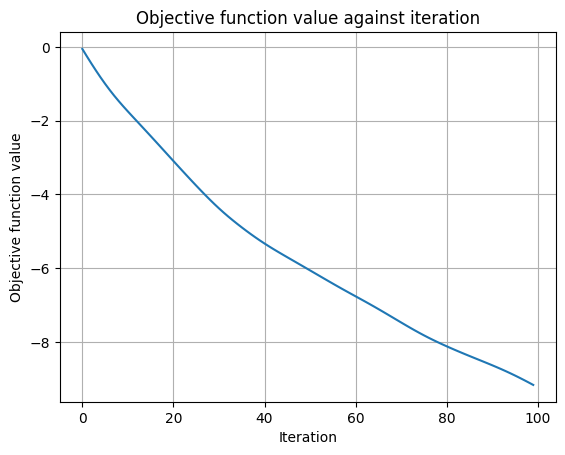

Trial 1: Ground state energy E0 ≈ -9.239516

Best ground state energy after 1 trials: E0 ≈ -9.239516
Magnetization <Z> per site ≈ 0.003722
Magnetization <X> per site ≈ 0.044196


In [67]:
num_trials = 1  # 尝试次数，可根据需要调整
best_energy = None
best_weights = None

# 损失函数alpha权重减小，优化器改为AdamW
optimizer = torch.optim.AdamW(qnn_model.parameters(), lr=0.01)
alpha = 0.02  # 更小的权重，主导能量优化

for trial in range(num_trials):
    # 随机初始化参数
    for param in qnn_model.parameters():
        nn.init.uniform_(param, a=-np.pi, b=np.pi)
    objective_func_vals = []

    for epoch in range(100):
        optimizer.zero_grad()
        output = qnn_model()
        # 计算mx
        x_obs = SparsePauliOp.from_list([(f"{'X'*n_qubits}", 1.0)])
        mx = estimator.run(circuits=ansatz_circuit, observables=x_obs, parameter_values=[qnn_model.weight.detach().numpy()]).result().values[0]
        loss = output.mean() + alpha * (1 - abs(mx))
        loss.backward()
        optimizer.step()
        callback_graph(qnn_model.weight, loss.item())

    # 计算当前trial的基态能量
    final_weights = qnn_model.weight.detach().numpy()
    estimator = Estimator()
    E0 = estimator.run(
        circuits=ansatz_circuit,
        observables=hamiltonian,
        parameter_values=[final_weights]
    ).result().values[0]
    print(f"Trial {trial+1}: Ground state energy E0 ≈ {E0:.6f}")

    if (best_energy is None) or (E0 < best_energy):
        best_energy = E0
        best_weights = final_weights

print(f"\nBest ground state energy after {num_trials} trials: E0 ≈ {best_energy:.6f}")

# 用最优参数输出物理量
estimator = Estimator()
E0 = estimator.run(circuits=ansatz_circuit, observables=hamiltonian, parameter_values=[best_weights]).result().values[0]

z_obs = SparsePauliOp.from_list([(f"{'Z'*n_qubits}", 1.0)])
mz = estimator.run(circuits=ansatz_circuit, observables=z_obs, parameter_values=[best_weights]).result().values[0] / n_qubits
print(f"Magnetization <Z> per site ≈ {mz:.6f}")

x_obs = SparsePauliOp.from_list([(f"{'X'*n_qubits}", 1.0)])
mx = estimator.run(circuits=ansatz_circuit, observables=x_obs, parameter_values=[best_weights]).result().values[0] / n_qubits
print(f"Magnetization <X> per site ≈ {mx:.6f}")